# **OUR APP**

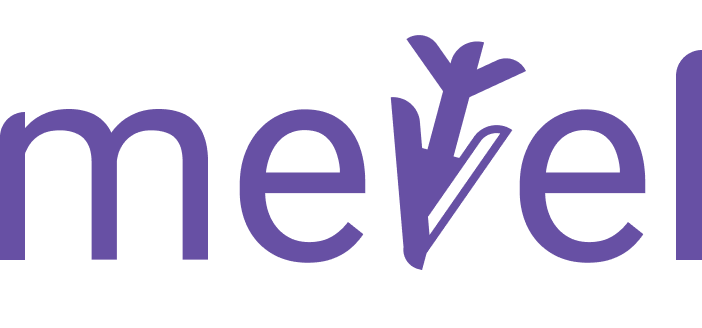

### **Introduction**

This notebook related to our project on mevel app.
To create ai recommendation based on machine learning. We build machine learning model with datasets from vacational picture around the world. The datasets which we use contain several specific category. Then we process the data until separate to general category. The final data have 5 categories related to label on our backend application such as:
- alam_darat
- alam_laut
- alam_salju
- seni
- sports

The label reflect to categories that could be user request on mevel app. Each category have different filtering on app. The model have a result that is one of the label that listed above.

### **Data Processing**

The result from data processing on the other file is separate data to 4980 file.
The data would be split on train and validation data. The ratio for the split is 4:1. So, the model could be evaluate in correct way and accurate for real life data.

In [ ]:
# mount google drive account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# extract data on format zip file
!unzip "/content/drive/MyDrive/Data Gambar Wisata Splitted/Data General/data_fix.zip" -d "/"

In [ ]:
# import necessary lib
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import os

In [ ]:
# make sure folder contain correct file
os.listdir('data')

['alam_darat', 'seni', 'alam_laut', 'sports', 'alam_salju']

In [ ]:
# declare data directory
base_dir = '/content/data'

# alam_darat_dir = os.path.join(base_dir, 'alam_darat')
# alam_laut_dir = os.path.join(base_dir, 'alam_laut')
# seni_dir = os.path.join(base_dir, 'seni')
# alam_salju_dir = os.path.join(base_dir, 'alam_salju')
# sports_dir = os.path.join(base_dir, 'sports')

In [ ]:
# to remove folder not necessary
import shutil
shutil.rmtree('/content/data/.ipynb_checkpoints')

In [ ]:
# data preparation with data generator
# split, augmentation, and processing data on correct size and format
# declare augmentation process
image_gen = ImageDataGenerator(rescale=1./255, 
                               validation_split=0.2,
                               rotation_range=35,
                               horizontal_flip=True,
                               shear_range = 0.25,
                               zoom_range=0.25,
                               fill_mode='wrap') 
# split data for train
train_dataset = image_gen.flow_from_directory(batch_size=32,
                                                 directory=base_dir,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical')
# split data for validate
validation_dataset = image_gen.flow_from_directory(batch_size=32,
                                                 directory=base_dir,
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical')

Found 3985 images belonging to 5 classes.
Found 995 images belonging to 5 classes.


### **Build Model**

Model build with tensorflow pretrained model MobilenetV2 with fine tuning to train the model with new datasets that we have. MobilenetV2 choosed because of its ability to detect image with a lot of image on multiclass prediction. So, this model match with our goals to predict label based on image that user send to our app. The model which we train use unfreezee layer from MobilenetV2

In [ ]:
# import mobilenet for transfer learning
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [ ]:
# image size declaration
IMG_SHAPE = (224, 224, 3)

# declare based model
base_model = MobileNetV2(input_shape=IMG_SHAPE, input_tensor=None,
                                                include_top=False, 
                                                weights='imagenet')

# unfreeze layer for training with new datasets
base_model.trainable = True

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# Model Architecture
model3 = tf.keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dropout(0.25),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(5, activation='softmax')
])

In [ ]:
# Compile Model and Give Information About Architecture
model3.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               1

In [ ]:
# callback to optimize time for training process
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if((logs.get('accuracy') > .7) and (logs.get('val_accuracy') > .7)):   
        print("\nReached %2.2f%% accuracy, so stopping training!!" %(.8*100))   
        self.model.stop_training = True

# reduce learning rate on several condition
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

In [ ]:
# Start training process
history = model3.fit(
    train_dataset,
    steps_per_epoch=8,
    epochs=100,
    validation_data=validation_dataset,
    validation_steps=10,
    callbacks=[MyCallback(), reduce_lr],
    verbose=2)

Epoch 1/100
8/8 - 75s - loss: 1.4362 - accuracy: 0.4219 - val_loss: 1.4157 - val_accuracy: 0.5375 - lr: 0.0010 - 75s/epoch - 9s/step
Epoch 2/100
8/8 - 63s - loss: 1.0315 - accuracy: 0.5820 - val_loss: 3.1002 - val_accuracy: 0.3812 - lr: 0.0010 - 63s/epoch - 8s/step
Epoch 3/100
8/8 - 63s - loss: 1.0991 - accuracy: 0.6289 - val_loss: 6.4403 - val_accuracy: 0.2188 - lr: 0.0010 - 63s/epoch - 8s/step
Epoch 4/100

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
8/8 - 64s - loss: 1.0352 - accuracy: 0.6328 - val_loss: 3.8813 - val_accuracy: 0.3375 - lr: 0.0010 - 64s/epoch - 8s/step
Epoch 5/100
8/8 - 64s - loss: 0.9840 - accuracy: 0.5977 - val_loss: 4.1341 - val_accuracy: 0.3125 - lr: 2.5000e-04 - 64s/epoch - 8s/step
Epoch 6/100
8/8 - 63s - loss: 1.0426 - accuracy: 0.6016 - val_loss: 4.0694 - val_accuracy: 0.2906 - lr: 2.5000e-04 - 63s/epoch - 8s/step
Epoch 7/100

Epoch 7: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
8/8 - 64s - loss: 0.8612 - ac

### **Evaluate**

In [ ]:
# class to predict
print(train_dataset.class_indices)

{'alam_darat': 0, 'alam_laut': 1, 'alam_salju': 2, 'seni': 3, 'sports': 4}


In [ ]:
# import to visualize training process evaluation
import matplotlib.pyplot as plt

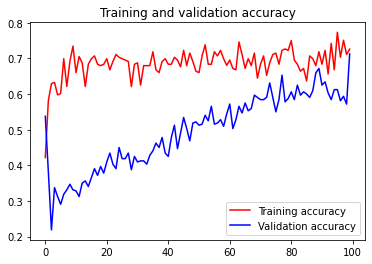

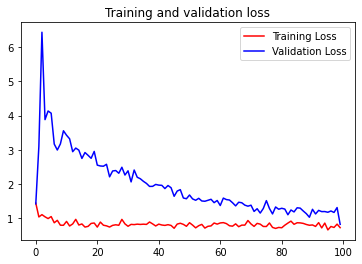

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving 1628945174502.jpg to 1628945174502.jpg
1628945174502.jpg
alam_darat


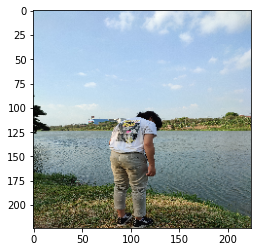

In [ ]:
# predict on new data based on our machine learning model
# import lib to visualize picture and predict result.
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline
 
uploaded = files.upload()

# for all images data that want to predict
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model3.predict(images, batch_size=10)
  class_dict = {v: k for k, v in train_dataset.class_indices.items()}
  print(fn)
  print(class_dict[np.argmax(classes)])

### **Save Model**

In [ ]:
# savemodel
model3.save("model_1")

INFO:tensorflow:Assets written to: model_1/assets


INFO:tensorflow:Assets written to: model_1/assets


In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
tflite_model = converter.convert()

# Save the model.
with open('model_1.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp69awz1c_/assets


INFO:tensorflow:Assets written to: /tmp/tmp69awz1c_/assets


In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('/content/model_1')
tflite_model = converter.convert()

# Save the model.
with open('model_1_bedametode.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
# zip model to download it
!zip -r /content/fashion.zip /content/model_1

  adding: content/model_1/ (stored 0%)
  adding: content/model_1/keras_metadata.pb (deflated 96%)
  adding: content/model_1/saved_model.pb (deflated 91%)
  adding: content/model_1/assets/ (stored 0%)
  adding: content/model_1/variables/ (stored 0%)
  adding: content/model_1/variables/variables.index (deflated 79%)
  adding: content/model_1/variables/variables.data-00000-of-00001 (deflated 8%)
